Today I want to talk about Givens rotations.  Givens rotations are a generalization of the rotation matrix you might remember from high school trig class.  Instead of rotating in the plane of a 2D matrix, we can rotated in any plane of a larger dimension matrix.  We'll use these rotations to selectively place zeros in a target matrix.  <!--more-->

### Rotations

In [1]:
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True) # no excessive scientific notation

I wanted to remind myself about the simplest possible rotations we make.  `matplotlib` didn't make me super happy, when I went to plot "pedagogical" vectors like you'd find in a trig. textbook.  The `matplotlib` interface (for `quiver` - i.e., a quiver of arrows/vectors) is designed for the use case of full-on "vector fields" that are very useful to visualize dynamic systems.  So, I wrote a small wrapper that did what I want:

In [2]:
# adding an orientation would be nice
def sane_quiver(vs, ax=None, colors=None):
    '''plot (0,0) origin column vectors'''
    vs = np.asarray(vs)
    assert vs.ndim == 2 and vs.shape[1] == 2  # ensure column vectors
    n = vs.shape[0]
    if not ax: ax = plt.gca()

    zs = np.zeros(n)
    xs = vs.T[0]
    ys = vs.T[1]
    
    props = {"angles":'xy', 'scale':1, 'scale_units':'xy'}
    ax.quiver(zs, zs, xs, ys, color=colors, **props)

    ax.set_aspect('equal')
    ax.set_axis_off()
    # if not square:
    #ax.set_xlim(xs.min()-1, xs.max()+1)
    #ax.set_ylim(ys.min()-1, ys.max()+1)
    # else: # square axes frame
    _min, _max = vs.min()-1, vs.max()+1
    ax.set_xlim(_min, _max)
    ax.set_ylim(_min, _max)
        

Let's make a small test vector and a simple rotation:

In [3]:
x = np.array([1.0, 1.0])

theta = np.pi/2

sin_th = np.sin(theta)
cos_th = np.cos(theta)

givens_rot = np.array([[ cos_th, sin_th],
                       [-sin_th, cos_th]])

Premultiplication by the transpose of `givens_rot` will rotate a vector *counter-clockwise* (CCW) in the *xy*-plane.  I'm not sure when/where/why/how the Givens form is the transpose form of the usual, highschool trig. textbook form (see, for example the definition of ["high school" R here](https://en.wikipedia.org/wiki/Rotation_matrix) and [Givens G here](https://en.wikipedia.org/wiki/Givens_rotation).  Also, $G$ agrees with the venerable Golab & VanLoan (3rd, pg. 215), so you can't really argue with it.  I'm going to blame it on row- versus column-major ordering.  I blame everything else on that, so why not?

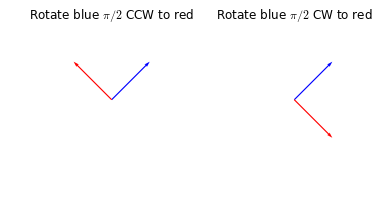

In [4]:
fig, (axL, axR) = plt.subplots(1,2)

#G.T.dot(X)
sane_quiver([x, givens_rot.T.dot(x)], axL, colors=['b', 'r'])
axL.set_title("Rotate blue $\pi/2$ CCW to red")

# X.dot(G)
sane_quiver([x, x.dot(givens_rot.T)], axR, colors=['b', 'r'])
axR.set_title("Rotate blue $\pi/2$ CW to red");

We can generalize $G=\begin{bmatrix}\cos(\theta) & \sin(\theta) \\ -\sin(\theta) & \cos(\theta)\end{bmatrix}$ to still be a rotation in one plane, but make that plane be an arbitrary plane in a larger space.  Here's an example for 3D:

$\renewcommand{\vec}[1]{\mathbf{#1}}\renewcommand{\norm}[1]{\|\vec{#1}\|}\renewcommand{\abs}[1]{\left\lvert#1\right\lvert}\renewcommand{\nvec}[2]{\vec{#1}_\mathrm{#2}}$

$$G=\begin{bmatrix}
1 & 0 & 0 \\ 
0 & \cos(\theta) & \sin(\theta) \\ 
0 & -\sin(\theta) & \cos(\theta)
\end{bmatrix}$$

and at the risk of belaboring the point, for 5D:
$$G=\begin{bmatrix}
1 & 0 & 0 & 0 & 0\\ 
0 & \cos(\theta) & 0 & \sin(\theta) & 0 \\ 
0 & 0 & 1 & 0 & 0 \\
0 & -\sin(\theta) & 0 & \cos(\theta) & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}$$


In general, we take a $(m,m)$ identity matrix and replace four elements with these trig. functions.  If we want our rotation plane to be on axes 2 and 4 (as in G_2), we replace G[2,2], G[2,4], G[4,2], and G[4,4].  Since two of these elements are on the diagonal, we replace two 1s (with the cosines).  The two off-diagonal elements replace two 0s with $\sin$ and its negative.  In G_2, if we called our axes (x,y,z,a,b), we would be performing a CCW rotation in the ya-plane.  More usually, if we called our axes $x_1 \dots x_5$, we would be rotating in the $x_2 x_4$ plane.

### Computing a Givens Zeroing Coefficient

If we rotate in a plane defined by two axes and we rotate just enough to get our vector pointed directly inline with one of those axes (assume the vector share a common origin/tail/starting point), then we have a $0$ component in *the other* axis.  Together with the fact that we can we pick the two axes out-of-a-hat, this means that we can *selectively* zero out single elements of a matrix using a Givens rotation.  Contrast this with Householder reflections which zero out *all-but-one* element of a row/column.  Put the two together, and we can start slicing and dicing matrices into different form pretty nicely.

In [5]:
# GvL pg. 216 : algo 5.1.3 * see also anderson(2000) via wikipedia for continuity concerns
def zeroing_givens_coeffs(x,z):
    ''' for the values x,z compute cos th, sin th 
        s.t. applying a Givens rotation G(cos th,sin th) 
             on 2 rows(or cols) with values x,z will
             maps x --> r and z --> 0'''
    if z == 0.0: # better:  abs(z) < np.finfo(np.double).eps
        return 1.0,0.0
    r = np.hypot(x,z) # C99 hypot is safe for under/overflow
    return x/r, -z/r

In [6]:
# from the 45deg .. pi/4 .. y=x line, 
# theta should be pi/4, we should rotate 
print np.sqrt(2)/2, np.sin(np.pi/4), np.cos(np.pi/4)
print zeroing_givens_coeffs(2,2)
print zeroing_givens_coeffs(4,4)


print zeroing_givens_coeffs(3,4)
print zeroing_givens_coeffs(4,3)

0.707106781187 0.707106781187 0.707106781187
(0.70710678118654746, -0.70710678118654746)
(0.70710678118654746, -0.70710678118654746)
(0.59999999999999998, -0.80000000000000004)
(0.80000000000000004, -0.59999999999999998)


Now, we can *apply* a Givens transformation by hand.  We do it in two steps:  (1)  create the appropriate Givens matrix as a $(2\ \mathrm{x}\ 2)$ array from the computed zeroing coefficients and (2) apply that on the correct rows (for a left Givens) or columns (for a right Givens).  Remember, on the left, we use the tranpose.

In [7]:
# column vector
x = np.array([1.0, 2, 3, 4]).reshape(4,1)

# compute coefficients
c,s = zeroing_givens_coeffs(20, 40)

# apply transformation (in-place)
givensT = np.array([[c, -s],
                    [s,  c]])
x[[1,3], :] = givensT.dot(x[[1,3],:])

print x

[[ 1.        ]
 [ 4.47213595]
 [ 3.        ]
 [ 0.        ]]


### Applying a Givens Rotation

Here, we've moved straight into Python land, so we'll be using zero-indexing now.  You've been warned!  And yes, I'm shamed.  I reworked these functions (slightly) in the next post, because I didn't like the separation of the "Givens" args (`c,s,r1,r2`) and `A` being lumped in the middle.

The form of Givens rotations means that *we can save a lot of work* when we multiply.  Most of a Givens matrix is $0$ - and much of the rest is an identity vector.  So, we can effectively *ignore* most of it.  On the left, we only need to update two rows.  On the right, it's two columns.  We'll see examples below.

In [8]:
# GvL, pg. 216 .... Section 5.1.9
def left_givensT((c,s), A, r1, r2):
    ''' update A <- G.T.dot(A) ... affects rows r1 and r2 '''
    givensT = np.array([[ c, -s],   # manually transposed 
                        [ s,  c]])
    A[[r1,r2],:] = np.dot(givensT, A[[r1,r2],:])

# A.dot(G) .... affects two cols of A
def right_givens((c,s), A, c1, c2):
    ''' update A <- A.dot(G) ... affects cols c1 and c2 '''
    givens = np.array([[ c, s],
                       [-s, c]])
    A[:,[c1, c2]] = np.dot(A[:,[c1, c2]], givens)

In [9]:
x = np.array([1.0, 2, 3, 4]).reshape(4,1)
print x

c,s = zeroing_givens_coeffs(2, 4)
left_givensT((c,s), x, 1,3)
print x

[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]]
[[ 1.        ]
 [ 4.47213595]
 [ 3.        ]
 [ 0.        ]]


In [10]:
# row vector
x = np.array([1.0, 2, 3, 4]).reshape(1,4)
print x

# zero the 2, this time
c_zero, c_other = 1, 3
c,s = zeroing_givens_coeffs(x[0,c_other], x[0,c_zero])
right_givens((c,s), x, c_other, c_zero)

print x

[[ 1.  2.  3.  4.]]
[[ 1.          0.          3.          4.47213595]]


In [11]:
x = np.arange(16.0).reshape(4,4)
c,s = zeroing_givens_coeffs(7,5)
right_givens((c,s), x, 3,1)
print x

[[  0.          -0.92998111   2.           3.02243861]
 [  4.           0.           6.           8.60232527]
 [  8.           0.92998111  10.          14.18221193]
 [ 12.           1.85996222  14.          19.76209859]]


You may have noticed that when I wanted to zero the `5` value, I had to swap the args to `zeroing_givens_coeff` (the zeroed *value* comes second) *and* swap the axes args to `right_givens` (the zeroed *position* comes second).  Ugh.  This implies that those two parameters (the order of them) are intimately coupled.  And making a programmer use coupled arguments is a recipe for disaster.  We'll talk about a higher level interface in the next post.  Incidentally, the two-step process is useful because we often have to apply the same transformation to more than one matrix at a time.  

### Using Givens Rotations to Perform a QR Decomposition

Let's take a look at how we'll *use* the Givens rotations, so we can design a decent interface for them.  

We can take an arbitrary matrix $\vec{A}$ uses (zeroing) Givens rotations to zero out entries.  As we do that, we get a sequence of Givens rotations $\vec{G_1},\vec{G_2},\vec{G_3},\dots$.  Eventually, we have $A=(\prod_i \vec{G_i}) \vec{Z}$ where $\vec{Z}$ has "lots" of zeros in it.  If we introduce those zeros in the right way, we can get $\vec{Z}$ to be upper-triangular (aka, $\vec{R}$) and then $\prod_i \vec{G_i} = Q$.  Presto, et voila, we have $QR$.  Note that the product of several orthogonal matrices (and rotations), is itself, orthogonal (one grand rotation).

To do this, we'll work from left-to-right column wise.  On the first column, we'll introduce a zeros from the bottom up until we get to the top row.  That top row will be modified by a zeroing Givens rotation, but it won't be zeroed.  And likewise for each additional column -- except we always stop at the diagonal.  Remember, as we walk across the columns, we move up the rows until we get to the diagonal, zeroing as we go.  The diagonal is modified (to $r$ coming out of our zeroing Givens rotation).  That column, above the diagonal, is untouched by the "walking up the column".  When we apply our $G_i$, two rows are rotated which will affect entries above the matrix diagonal -- but to the right, not to the top.  The entries to the left, in those two rows, will already have been zeroed and it can be ignored.

In [12]:
A = np.arange(1.0, 10.0).reshape(3,3)
print A

col = 0
for row in reversed(xrange(1,3)): # row in [2, 1]
    # zeroing the lower row, 
    # so row-1 is first arg and row is second arg
    coeffs = zeroing_givens_coeffs(A[row-1, col], A[row, col])
    left_givensT(coeffs, A[:, col:], row-1, row) 
    print A

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]
[[  1.           2.           3.        ]
 [  8.06225775   9.42663983  10.79102191]
 [  0.          -0.3721042   -0.74420841]]
[[  8.1240384    9.6011363   11.07823419]
 [  0.          -0.8244515   -1.648903  ]
 [  0.          -0.3721042   -0.74420841]]


We walk up a fixed column (here, the first column) and introduce zeros into it.  As we do this, we only affect the two rows we are currently "attacking" (`row` and `row-1`).  Since we'll be processing the remaining columns, we don't care that we've fiddled with the values.  We'll zero out the below-the-diagonal entries.  But one quick question.  We're going to zero out much of the second column.  When we rotate the bottom two rows, why don't the zeros (that we introduced in the first pass) get modified as well?  

Consider the bottom-left position during the start of the second pass.  When we compute $G^TA$ (not Grandtheft Auto, btw), the position $(2,0)$ comes from `dot(G.T[2,:], A[:,0])` (i.e., the row-column rule of matrix multiplication).  The two things being dotted are "just" vectors:  let `g=G.T[2,:]` and `a=A[:,0]` for simplicity sake.  `g` comes from a Givens rotation for $(1,2)$, so the only entries that are non-zero are entries `1` and `2` (said another way, `g` is zero at position `1`).  `a` currently has only one non-zero:  position `0`.  Put these two facts together and every term in the dot-product either gets a zero from `g` or from `a`.  So, the whole dot-product is zero. 

As we introduce more and more zero below the diagonal, the same argument will hold for all spots to the left of our current "working" column and below the diagonal.  Put the above code (which works for just one column) in a loop over all columns gives us:

In [13]:
# GvL:  page 227 ...... algorithm 5.2.2
# updates A in-place to produce 
def givens_qr(A):
    m,n = A.shape
    Q = np.eye(m)
    for c in xrange(n):
        for r in reversed(xrange(c+1, m)):  # m-1, m-2, ... c+2, c+1
            # in this row and the previous row, use zeroing givens to
            # place a zero in the lower row
            coeffs = zeroing_givens_coeffs(A[r-1, c], A[r,c])
            left_givensT(coeffs, A[:, c:], r-1, r) 
            # left_givensT(coeffs, A[r-1:r+1, c:], 0, 1)
            left_givensT(coeffs, Q[:, c:], r-1, r)
    return Q

There are more efficient ways to store and compute a product of Givens rotations.  Here, we simply accumulate them in $\vec{Q}$, which starts out as an identity matrix.  See G&VL (3rd), pages 217, 218, and 227, for more efficient possibilities.

In [14]:
A = np.arange(1.0, 10.0).reshape(3,3)
print A
print "nla.qr's R"
print nla.qr(A)[1]

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]]
nla.qr's R
[[ -8.1240384   -9.6011363  -11.07823419]
 [  0.           0.90453403   1.80906807]
 [  0.           0.           0.        ]]


In [15]:
givens_qr(A)
print "my givens R"
print A

my givens R
[[  8.1240384    9.6011363   11.07823419]
 [  0.           0.90453403   1.80906807]
 [  0.           0.           0.        ]]


### Conclusion

Like many posts, I bit off more than I thought.  This got a bit long winded and I have more to say about Givens rotations and using them to selectively zero out entried in a particular kind of matrix:  an upper bidiagonal matrix that has, gasp!, a blemish.  Until next time ...